# Unbinned Profiled Unfolding

In [1]:
%load_ext tensorboard
import os, sys
import datetime
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, ProgressBar
from tqdm import tqdm
from sklearn.metrics import accuracy_score
dvc = "cuda" if torch.cuda.is_available() else "cpu"
device = "gpu" if torch.cuda.is_available() else "cpu"
# dvc=device="cpu"
print(f"Using {device} device")

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using gpu device


In [2]:
# Data sets for training W0 and training W1

class w0_dataset(Dataset):
    def __init__(self, T, R):
        super(w0_dataset, self).__init__()
        
        self.R = R
        self.T = T
        
    def __len__(self):
        return len(self.R)

    def __getitem__(self, idx):
        return torch.tensor([self.T[idx]]), torch.tensor([self.R[idx]])
    
class w1_dataset(Dataset):
    def __init__(self, T0, R0, T1, R1, theta0, theta1):
        super(w1_dataset, self).__init__()
        
        # it is possible that the same index will be picked. Consider make all selected indices unique?
        self.R0 = R0
        self.T0 = T0
        self.R1 = R1
        self.T1 = T1
        self.theta0 = theta0
        self.theta1 = theta1
        self.inds = np.random.randint(0,len(R1),len(R0))
                
    def __len__(self):
        return len(self.R0)*2

    def __getitem__(self, idx):
        label = idx % 2
        i = idx // 2
#         ran = np.random.randint(0,len(self.R1))
        if label == 1:
            return torch.tensor([self.R1[self.inds[i]]]), torch.tensor([self.T0[i]]), torch.tensor([self.T1[self.inds[i]]]), torch.tensor([self.theta0[i]]), torch.tensor([self.theta1[self.inds[i]]]), torch.tensor([label])
#             return torch.tensor([self.R1[ran]]), torch.tensor([self.T0[i]]), torch.tensor([self.T1[ran]]), torch.tensor([self.theta0[i]]), torch.tensor([self.theta1[ran]]), torch.tensor([label])
        else:
            return torch.tensor([self.R0[i]]), torch.tensor([self.T0[i]]), torch.tensor([self.T1[self.inds[i]]]), torch.tensor([self.theta0[i]]), torch.tensor([self.theta1[self.inds[i]]]), torch.tensor([label])
        

In [3]:
# Loss function (NLL)

class NLLLoss(nn.Module):

    def __init__(self, obs_data, bins, normalize=False, device="cpu"):
        super(NLLLoss, self).__init__()
        self.normalize = normalize
        self.dvc = device
        if type(obs_data) == torch.Tensor:
            self.obs_data = obs_data.float().to(self.dvc)
        elif type(obs_data) == np.ndarray:
            self.obs_data = torch.from_numpy(obs_data).float().to(self.dvc)
        elif type(obs_data) == list:
            self.obs_data = torch.tensor(obs_data).float().to(self.dvc)
        if type(bins) == torch.Tensor:
            self.bins = bins.float().to(self.dvc)
        elif type(bins) == np.ndarray:
            self.bins = torch.from_numpy(bins).float().to(self.dvc)
        elif type(bins) == list:
            self.bins = torch.tensor(bins).float().to(self.dvc)
        self.h_obs_data = torch.tensor([(torch.bucketize(self.obs_data, self.bins)==i).sum() for i in range(1, len(self.bins))]).to(self.dvc)
        self.y_obs_data = len(self.obs_data)
        
    def forward(self, R, weights, theta):
        h_R = None
        for i in range(1, len(self.bins)):
            h_R_i = torch.mul((torch.bucketize(R, self.bins)==i), weights).sum().reshape(1)
            h_R = torch.cat((h_R, h_R_i)) if h_R != None else h_R_i
        if self.normalize: h_R = h_R * self.y_obs_data / h_R.sum()
        log_gauss = torch.neg(torch.div(torch.pow(theta, 2), 2.))
        nll = torch.neg(torch.add(torch.sub(torch.mul(self.h_obs_data, torch.log(h_R)), h_R).sum(), log_gauss))
        return nll


In [4]:
# All the networks (W0, W1 and theta)

class w0_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=False, std_params=None):
        super(w0_network, self).__init__()
            
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(1 if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        
    def forward(self, T):
        T = (T-self.std_params[0])/self.std_params[1]
        logit = self.linear_relu_stack(T)
        if self.sigmoid:
            return logit / (1 - logit)
        else:
            return torch.exp(logit)
        
class w0_dummy(nn.Module):
    def __init__(self):
        super(w0_dummy, self).__init__()
        
    def forward(self, T):
        return 1
    
class w1_analytic(nn.Module):  
    def __init__(self, epsilon, beta, d, delta_epsilon=0):
        super(w1_analytic, self).__init__()
        self.epsilon = epsilon
        self.delta_epsilon = delta_epsilon
        self.beta = beta
        self.d = d
        
    def forward(self, T, R, theta, theta0=None, T1=None):
        c = theta * self.delta_epsilon + self.epsilon
        return (self.epsilon/c)*torch.exp(-0.5*(R-T-self.d)**2/c**2+0.5*(R-T-self.beta)**2/self.epsilon**2)
    
class w1_network(nn.Module):
    def __init__(self, nodes=[50, 50, 50], sigmoid=True, std_params=None):
        super(w1_network, self).__init__()
        
        self.std_params = std_params
        self.sigmoid = sigmoid
        self.linear_relu_stack = nn.Sequential()
        for i in range(len(nodes)+1):
            self.linear_relu_stack.add_module(f"linear_{i}", nn.Linear(5 if i==0 else nodes[i-1], nodes[i] if i<len(nodes) else 1))
            if i<len(nodes): self.linear_relu_stack.add_module(f"relu_{i}", nn.ReLU())
        if self.sigmoid: self.linear_relu_stack.add_module("sigmoid", nn.Sigmoid())
        # self.loss_fn = nn.BCELoss()
        
    def forward(self, T0, R, theta1, theta0, T1):
        T0 = (T0-self.std_params[0])/self.std_params[1]
        T1 = (T1-self.std_params[0])/self.std_params[1]
        R = (R-self.std_params[2])/self.std_params[3]
        x = torch.cat([R, T0, theta0, T1, theta1], dim=1)
#         x = torch.cat([R, T0, T1], dim=1)
        logit = self.linear_relu_stack(x)
        if self.sigmoid:
            return (logit) / (1 - logit + 0.00000000000001)
        else:
            return torch.exp(logit)
    
class theta_module(nn.Module):
    def __init__(self, init_value=0.):
        super(theta_module, self).__init__()
        self.theta = nn.Parameter(torch.ones(1) * init_value)
        
    def forward(self):
        return self.theta


In [5]:
# training and testing utilities

def train_w1(train_dataloader, val_dataloader, model_w1, loss_fn, optimizer, max_epoch=1000, patience=10):
    
    print("===================== Model W1 =====================")
    print(model_w1)
    
    best_state = model_w1.state_dict()
    best_epoch = None
    best_val_loss = None
    i_try = 0
    
    size = len(train_dataloader.dataset)
    for epoch in range(max_epoch):
        
        # train
        model_w1.train()
        for batch, (R, T0, T1, theta0, theta1, label) in enumerate(train_dataloader):
            R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

            W = model_w1(T0, R, theta1, theta0, T1)
            logit = W/(W + 1)
            loss = loss_fn(logit, label.double())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss, current = loss.item(), (batch+1) * len(R)
            print("\r" + f"[Epoch {epoch:>3d}] [{current:>5d}/{size:>5d}] [Train_loss: {loss:>7f}]", end="")
        
        # now evaluate performance at the epoch end
        model_w1.eval()
        
        # evaluate loss for traing set
        Ws, labels = None, None
        with torch.no_grad():
            for batch, (R, T0, T1, theta0, theta1, label) in enumerate(train_dataloader):
                R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

                W = model_w1(T0, R, theta1, theta0, T1)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
            logits = Ws/(Ws + 1)
            train_loss = loss_fn(logits, labels.double())
            
        # evaluate loss for validation set
        Ws, labels = None, None
        with torch.no_grad():
            for batch, (R, T0, T1, theta0, theta1, label) in enumerate(val_dataloader):
                R, T0, T1, theta0, theta1, label = R.to(dvc), T0.to(dvc), T1.to(dvc), theta0.to(dvc), theta1.to(dvc), label.to(dvc)

                W = model_w1(T0, R, theta1, theta0, T1)
                Ws = torch.cat([Ws, W]) if Ws is not None else W
                labels = torch.cat([labels, label]) if labels is not None else label
            logits = Ws/(Ws + 1)
            val_loss = loss_fn(logits, labels.double())
        
        print("\r" + " "*(50), end="")
        print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}]")
        
        if best_val_loss == None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model_w1.state_dict())
            best_epoch = epoch
            i_try = 0
        elif i_try < patience:
            i_try += 1
        else:
            print(f"Early stopping! Restore state at epoch {best_epoch}.")
            print(f"[Best_val_loss: {best_val_loss:>7f}]")
            model_w1.load_state_dict(best_state)
            break
            
def test_w1(test_dataloader, model_w1, theta):
       
    # now evaluate performance at the epoch end
    model_w1.eval()

    # evaluate loss for test set
    Ts, Rs, W1s = None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = (R+0.0000000001)/(R+0.0000000001)

            # Compute weights
            W1 = model_w1(T, R, ones*theta, ones*theta, T)
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
    return Ts, Rs, W1s

def train_w0(train_dataloader, val_dataloader, model_w0, model_w1, model_theta, loss_fn, optimizer, optimizer1=None, max_epoch=1000, patience=10):
    
    print("===================== Model W0 =====================")
    print(model_w0)
    print("===================== Model W1 =====================")
    print(model_w1)
    print(f"Initial theta: {model_theta().item()}")
    
    model_w1.eval()
    
    best_state = model_w0.state_dict()
    best_theta = model_theta.state_dict()
    best_epoch = None
    best_val_loss = None
    i_try = 0
    
    print("====================================================")
    print(" Start optimizing the W0 model and theta")
    print("====================================================")
    
    size = len(train_dataloader.dataset)
    for epoch in range(max_epoch):
        
        # train
        model_w0.train()
        model_theta.train()
        for batch, (T, R) in enumerate(train_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = (R+0.0000000001)/(R+0.0000000001)

            # Compute weights
            theta = model_theta()[0]
            W = model_w0(T) * model_w1(T, R, ones*theta, ones*theta, T)
            loss = loss_fn(R, W, theta)

            # Backpropagation
            optimizer.zero_grad()
            if optimizer1 != None:
                optimizer1.zero_grad()
            loss.backward()
            optimizer.step()
            if optimizer1 != None:
                optimizer1.step()
            
            loss, current = loss.item(), (batch+1) * len(T)
            print("\r" + f"[Epoch {epoch:>3d}] [{current:>5d}/{size:>5d}] [Train_loss: {loss:>7f}] [Theta: {model_theta().item()}]", end="")
        
        # now evaluate performance at the epoch end
        model_w0.eval()
        model_theta.eval()
        
        # evaluate loss for traing set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(train_dataloader):
                T, R = T.to(dvc), R.to(dvc)

                # Compute weights
                theta = model_theta()[0]
                W = model_w0(T) * model_w1(T, R, ones*theta, ones*theta, T)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            train_loss = loss_fn(Rs, Ws, theta)
            
        # evaluate loss for validation set
        Rs, Ws = None, None
        with torch.no_grad():
            for batch, (T, R) in enumerate(val_dataloader):
                T, R = T.to(dvc), R.to(dvc)

                # Compute weights
                theta = model_theta()[0]
                W = model_w0(T) * model_w1(T, R, ones*theta, ones*theta, T)
                Rs = torch.cat([Rs, R]) if Rs is not None else R
                Ws = torch.cat([Ws, W]) if Ws is not None else W
            val_loss = loss_fn(Rs, Ws, theta)
        
        print("\r" + " "*(80), end="")
        print("\r" + f"[Epoch {epoch:>3d}] [Train_loss: {train_loss:>7f}] [Val_loss: {val_loss:>7f}] [Theta: {model_theta().item()}]")
        
        if best_val_loss == None or val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model_w0.state_dict())
            best_theta = copy.deepcopy(model_theta.state_dict())
            best_epoch = epoch
            i_try = 0
        elif i_try < patience:
            i_try += 1
        else:
            print(f"Early stopping! Restore state at epoch {best_epoch}.")
            print(f"[Best_val_loss: {best_val_loss:>7f}]")
            print(f"FittedM theta: {theta_model().item()}")
            model_w0.load_state_dict(best_state)
            model_theta.load_state_dict(best_theta)
            break
        
        
def test_w0(test_dataloader, model_w0, model_w1, model_theta, loss_fn):
       
    # now evaluate performance at the epoch end
    model_w0.eval()
    model_w1.eval()
    model_theta.eval()

    # evaluate loss for test set
    Ts, Rs, Ws, W0s, W1s = None, None, None, None, None
    with torch.no_grad():
        for batch, (T, R) in enumerate(test_dataloader):
            T, R = T.to(dvc), R.to(dvc)
            ones = (R+0.0000000001)/(R+0.0000000001)

            # Compute weights
            W0 = model_w0(T)
            theta = model_theta()[0]
#             W0 = torch.tensor(1.0)
            W1 = model_w1(T, R, ones*theta, ones*theta, T)
            W = W0 * W1
            Ts = torch.cat([Ts, T]) if Ts is not None else T
            Rs = torch.cat([Rs, R]) if Rs is not None else R
            W0s = torch.cat([W0s, W0]) if W0s is not None else W0
            W1s = torch.cat([W1s, W1]) if W1s is not None else W1
            Ws = torch.cat([Ws, W]) if Ws is not None else W
        test_loss = loss_fn(Rs, Ws, theta)

    print(f"[Test_loss: {test_loss:>7f}]")
    return Ts, Rs, Ws, W0s, W1s

In [6]:
# Visualization

class comparison_plots_with_ratio:
    
    def __init__(self, xmin, xmax, nbins, xlabel=r"$T$", header="Gaussian Example", density=True, save_name=None):
        
        self.xmin = xmin
        self.xmax = xmax
        self.nbins = nbins
        self.density = density
        self.save_name = save_name
        self.nTt = None
        self.bTt = None
        self.nTs = []
        self.bTs = []
        self.argss = []
        
        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
        
        self.ax0 = plt.subplot(gs[0])
        self.ax0.yaxis.set_ticks_position('both')
        self.ax0.xaxis.set_ticks_position('both')
        self.ax0.tick_params(direction="in", which="both")
        plt.xticks(fontsize=0)
        plt.yticks(fontsize=20)
        self.ax0.minorticks_on()
        
        plt.ylabel("Normalized to Unity" if self.density else "Events", fontsize=20)
        plt.xlim([xmin,xmax])
        plt.title(header,loc="right",fontsize=20, fontstyle="italic")
        
        self.ax1 = plt.subplot(gs[1])
        self.ax1.yaxis.set_ticks_position('both')
        self.ax1.xaxis.set_ticks_position('both')
        self.ax1.tick_params(direction="in",which="both")
        self.ax1.minorticks_on()
        
        plt.xlim([xmin,xmax])
        plt.locator_params(axis='x', nbins=6)
        plt.xlabel(xlabel,fontsize=20)
        plt.ylabel("Data/Pred.",fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=15)
        plt.axhline(y=1,linewidth=2, color='gray')   
        plt.ylim(0.5,1.5)
        
    def add_data(self, data, label, target=False, weights=None, histtype=None, color=None, ls=None, lw=None, alpha=None):
        args = {"label": label}
        if type(weights) != type(None): args["weights"] = weights
        if type(histtype) != type(None): args["histtype"] = histtype
        if type(color) != type(None): args["color"] = color
        if type(ls) != type(None): args["ls"] = ls
        if type(lw) != type(None): args["lw"] = lw
        if type(alpha) != type(None): args["alpha"] = alpha
        nT, bT, _ = self.ax0.hist(data, bins=np.linspace(self.xmin, self.xmax, self.nbins), density=self.density, **args)
        if target:
            self.nTt = nT
            self.bTt = bT
        else:
            self.nTs.append(nT)
            self.bTs.append(bT)
            self.argss.append(args)
        
    def plot_ratio(self):
        if type(self.nTt) == type(None):
            return
        for nT, bT, _args in zip(self.nTs, self.bTs, self.argss):
            args = {}
            if "color" in _args: args["color"] = _args["color"]
            if "ls" in _args: args["ls"] = _args["ls"]
            self.ax1.plot(0.5*(self.bTt[1:]+self.bTt[:-1]),self.nTt/(0.000001+nT), **args)
            
    def save(self):
        if type(self.save_name) == type(None):
            return
        os.makedirs("plot", exist_ok=True)
        if os.path.isfile(f"plot/{self.save_name}.pdf"):
            i = 0
            while os.path.isfile(f"plot/{self.save_name}_{i}.pdf"):
                i += 1
            self.save_name = f"{self.save_name}_{i}"
        plt.savefig(f"plot/{self.save_name}.pdf", bbox_inches='tight')
    
    def show(self):
        self.plot_ratio()
        self.ax0.locator_params(axis='y', nbins=6)
        self.ax0.legend(frameon=False,fontsize=20, loc="upper left")
        self.save()
        plt.show()
        plt.clf()

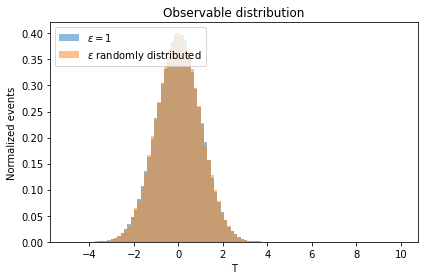

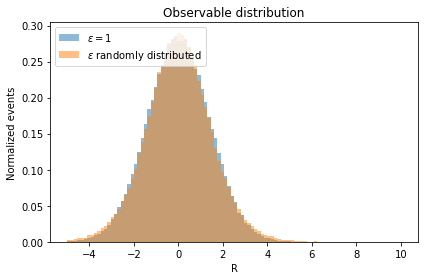

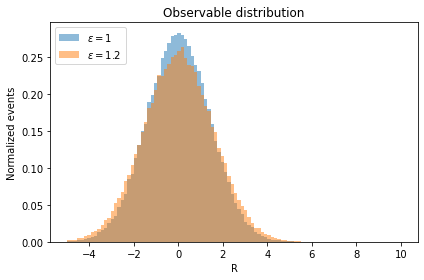

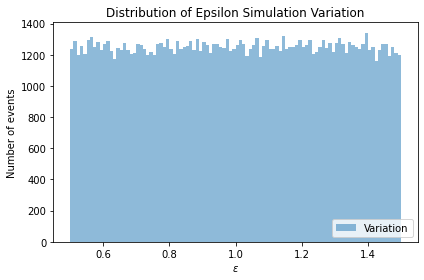

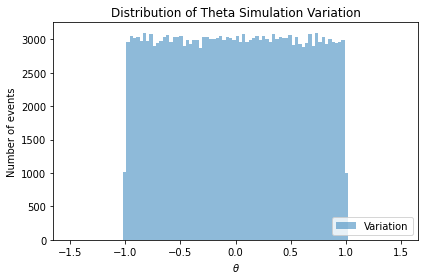

In [7]:
# Generate toy data for W1 training

Nsim = 200000
Ntest = 100000

# simulation
mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

# simulation with theta variation (theta value randomly sampled)
epsilon0_sim = np.random.uniform(0.2, 1.8, Nsim)
epsilon1_sim = np.random.uniform(0.2, 1.8, Nsim) # used for training
delta_epsilon = 0.8
theta0_sim = (epsilon0_sim-epsilon_sim)/delta_epsilon
theta1_sim = (epsilon1_sim-epsilon_sim)/delta_epsilon
R1_sim = []
for i in range(Nsim):
    # use the same T_sim for R_sim variation
    R1_sim.append(np.random.normal(T_sim[i]+beta_sim, epsilon1_sim[i]))
R1_sim = np.array(R1_sim)

# test
epsilon_test = 1.2
theta_test = (epsilon_test-epsilon_sim)/delta_epsilon
T_test = np.random.normal(mu_sim,sigma_sim,Ntest)
R_test0 = np.random.normal(T_test+beta_sim,epsilon_sim)
R_test1 = np.random.normal(T_test+beta_sim,epsilon_test)

plt.hist(T_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(T_test, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon$ randomly distributed", alpha=0.5)
plt.xlabel('T')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(R_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(R1_sim, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon$ randomly distributed", alpha=0.5)
plt.xlabel('R')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(R_test0, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_sim}$", alpha=0.5)
plt.hist(R_test1, range=(-5, 10), density=True, bins=100, label=f"$\\epsilon={epsilon_test}$", alpha=0.5)
plt.xlabel('R')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(epsilon1_sim, range=(0.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\epsilon$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Epsilon Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

plt.hist(theta1_sim, range=(-1.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.xlabel(r'$\theta$')
plt.ylabel('Number of events')
plt.title(r'Distribution of Theta Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

In [8]:
# Convert data into W1 dataset, data loaders and create loss function

w1_ds = w1_dataset(T_sim, R_sim, T_sim, R1_sim, theta0_sim, theta1_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    np.concatenate((R_sim, R1_sim)).mean(),
    np.concatenate((R_sim, R1_sim)).std()
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w1_ds_train, w1_ds_test = random_split(w1_ds, [len(w1_ds)//2, len(w1_ds)-len(w1_ds)//2])#, generator=torch.Generator().manual_seed(42))
w1_dataloader_train = DataLoader(w1_ds_train, batch_size=64, shuffle=True, num_workers=12)
w1_dataloader_test = DataLoader(w1_ds_test, batch_size=64, shuffle=False, num_workers=12)

loss_fn = nn.BCELoss()

[0.0007723404235673109, 0.9983687686112697, 0.005115538066287882, 1.4464954868495299]


In [9]:
# Create W1 model and training it!

### PLEASE ENTER A NEW MODEL NAME FOR W1 ###
today = str(datetime.date.today())
w1_model_name = f'w1_Gaussian1D_deltaEpsilon0.8_{today}'

w1_model_network = w1_network(sigmoid=True, std_params=std_params).double().to(dvc)
optimizer = optim.Adam(w1_model_network.parameters(), lr=0.001)
train_w1(w1_dataloader_train, w1_dataloader_test, w1_model_network, loss_fn, optimizer)

torch.save(w1_model_network, f'model/w1/{w1_model_name}.pth')

===================== Model W1 =====================
w1_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=5, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
[Epoch   0] [Train_loss: 0.502793] [Val_loss: 0.501957]
[Epoch   1] [Train_loss: 0.497859] [Val_loss: 0.497197]
[Epoch   2] [Train_loss: 0.497038] [Val_loss: 0.496358]
[Epoch   3] [Train_loss: 0.496954] [Val_loss: 0.496528]
[Epoch   4] [Train_loss: 0.496773] [Val_loss: 0.496181]
[Epoch   5] [Train_loss: 0.496436] [Val_loss: 0.496328]
[Epoch   6] [Train_loss: 0.498505] [Val_loss: 0.498206]
[Epoch   7] [Train_loss: 0.496441] [Val_loss: 0.496295]
[Epoch   8] [Train_loss: 0.498927] [Val_loss: 0.499021]
[Epoch   9] [Train_loss: 0.497327] [

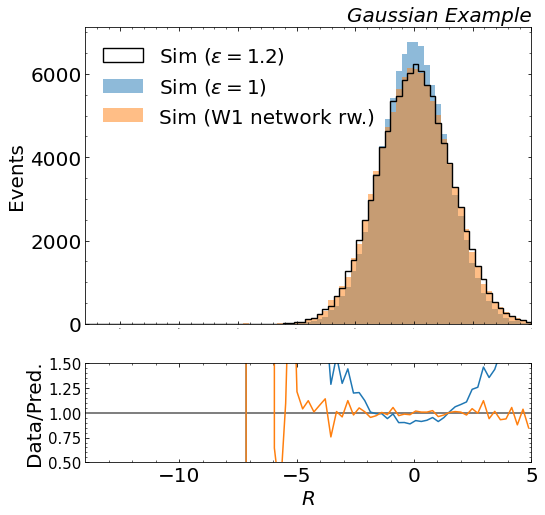

<Figure size 432x288 with 0 Axes>

In [14]:
# Test the trained W1 model

w1_model_name_0 = 'w1_Gaussian1D_deltaEpsilon0.8_2022-11-15'

w1_model_network_0 = torch.load(f'model/w1/{w1_model_name_0}.pth').to(dvc)

w1_model_analytic = w1_analytic(1, 0., 0., 0.8).double().to(dvc)

today = str(datetime.date.today())

w1_test_ds = w0_dataset(T_test, R_test0)
w1_test_dataloader = DataLoader(w1_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, W1s_0 = test_w1(w1_test_dataloader, w1_model_analytic, theta_test)
Ts_0, Rs_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-14, 5, 80, xlabel=r"$R$", density=False, save_name=f"Gaussian1D_Compare_R_forW1network_{today}")
cpwr.add_data(R_test1, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0, label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0, weights=W1s_0, label="Sim (W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

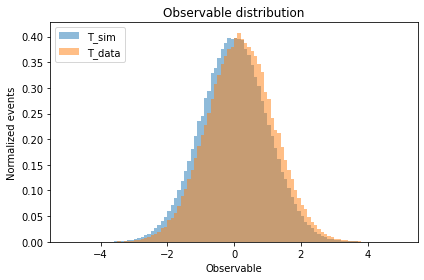

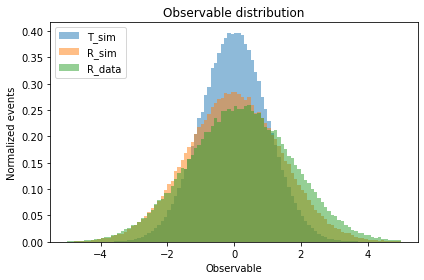

<Figure size 432x288 with 0 Axes>

In [7]:
# Generate data for W0 training (as well as theta)

Ndata = 100000
Nsim = 200000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.2
sigma_data = 1
beta_data = 0
epsilon_data = 1.2

# simulation
T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

# data
T_data = np.random.normal(mu_data,sigma_data,Ndata)
R_data = np.random.normal(T_data+beta_data,epsilon_data)

plt.hist(T_sim, range=(-5, 5), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(T_data, range=(-5, 5), density=True, bins=100, label="T_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(T_sim, range=(-5, 5), density=True, bins=100, label="T_sim", alpha=0.5)
plt.hist(R_sim, range=(-5, 5), density=True, bins=100, label="R_sim", alpha=0.5)
plt.hist(R_data, range=(-5, 5), density=True, bins=100, label="R_data", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Normalized events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

In [8]:
# Load W1 model and convert data into W0 datasets and data loaders
w0_ds = w0_dataset(T_sim, R_sim)
std_params = [
    T_sim.mean(),
    T_sim.std(),
    R_sim.mean(),
    R_sim.std()
]
print(std_params)
# split samples to 50% train and 50% test sets (can be adjusted)
w0_ds_train, w0_ds_test = random_split(w0_ds, [len(w0_ds)//2, len(w0_ds)-len(w0_ds)//2])#, generator=torch.Generator().manual_seed(42))
w0_dataloader_train = DataLoader(w0_ds_train, batch_size=len(w0_ds_train), shuffle=True, num_workers=12)
w0_dataloader_test = DataLoader(w0_ds_test, batch_size=len(w0_ds_test), shuffle=False, num_workers=12)

# w1_model_analytic = w1_analytic(1, 0., 0., 0.8).double().to(dvc)
# w1_model_name = "w1_analytic_gaussian"

w1_model_name = 'w1_Gaussian1D_deltaEpsilon0.8_2022-11-15'
w1_model_network = torch.load(f'model/w1/{w1_model_name}.pth')

loss_fn = NLLLoss(R_data, np.linspace(-5,5,20), normalize=False, device=dvc)

[0.0010700284697801026, 1.0000679122820262, -0.0006865181201714441, 1.4114664838330473]


In [16]:
# Create W0 model and train it (also theta)!

### PLEASE ENTER A NEW MODEL NAME FOR W0 AND THETA ###
today = str(datetime.date.today())
w0_model_name = f'w0_Gaussian1D_mu0.2epsilon1.2_20bins_Lr0p0095_{w1_model_name}_{today}'
# theta_model_name = f'theta_initial0_doubleGaussian_mu0.2epsilon1.2_20bins_Lr0p0005_with_w0_{w1_model_name}_{today}'

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0.25).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
# ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.001)
# optimizer_1 = optim.Adam(theta_model.parameters(), lr=0.001)

train_w0(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1_model_network, theta_model, loss_fn, optimizer)#, optimizer1=optimizer_1)
torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')
# torch.save(theta_model, f'model/theta/{theta_model_name}.pth')

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1 =====================
w1_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=5, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )
)
Initial theta: 0.25
 Start optimizing the W0 model and theta
[Epoch   0] [Train_loss: -798018.503715] [Va

In [17]:
print(f'model/w0/{w0_model_name}.pth')
print(theta_model().item()*0.8+1)

model/w0/w0_Gaussian1D_mu0.2epsilon1.2_20bins_Lr0p0095_w1_Gaussian1D_deltaEpsilon0.8_2022-11-15_2023-01-16.pth
1.2


[Test_loss: -799743.716712]


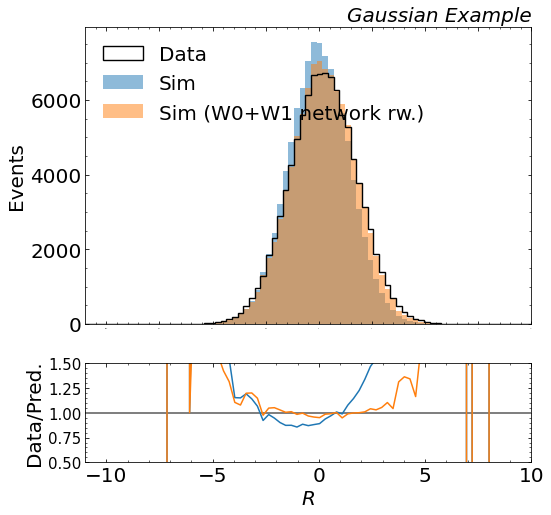

<Figure size 432x288 with 0 Axes>

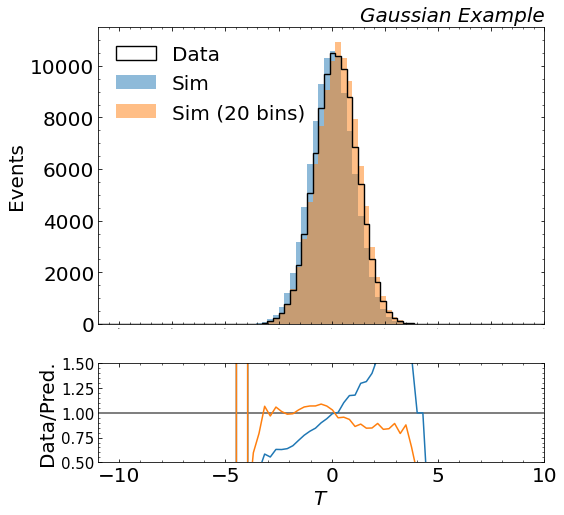

<Figure size 432x288 with 0 Axes>

In [18]:
# Test the trained W0 model and fitted theta value

w0_model_network_0 = w0_model_network
theta_model = theta_module(0.25).to(dvc)
# w0_model_name_0 = 'w0_v1_epsilon0.2_mu0.8sigma1.5_20bins_sigmoid_2022-10-07'
# w0_model_network_0 = torch.load(f'model/w0/{w0_model_name_0}.pth')

today = str(datetime.date.today())

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1_model_network, theta_model, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$R$", density=False, save_name=f"Compare_R_{today}")
cpwr.add_data(R_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0, weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$T$", density=False, save_name=f"Compare_T_{today}")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (20 bins)", alpha=0.5, color='tab:orange')
cpwr.show()

In [21]:
# Create W0 model and train it (also theta)!

### PLEASE ENTER A NEW MODEL NAME FOR W0 AND THETA ###
today = str(datetime.date.today())
w0_model_name = f'w0_Gaussian1D_mu0.2epsilon1.2_20bins_Lr0p0095_with_theta_initial0_{w1_model_name}_{today}'
theta_model_name = f'theta_initial0_doubleGaussian_mu0.2epsilon1.2_20bins_Lr0p0005_with_w0_{w1_model_name}_{today}'

w0_model_network = w0_network(sigmoid=False, std_params=std_params).double().to(dvc)
theta_model = theta_module(0.).to(dvc)

ml = nn.ModuleList()
ml.append(w0_model_network)
ml.append(theta_model)

optimizer = optim.Adam(ml.parameters(), lr=0.001)
# optimizer_1 = optim.Adam(theta_model.parameters(), lr=0.001)

train_w0(w0_dataloader_train, w0_dataloader_test, w0_model_network, w1_model_analytic, theta_model, loss_fn, optimizer)#, optimizer1=optimizer_1)
torch.save(w0_model_network, f'model/w0/{w0_model_name}.pth')
torch.save(theta_model, f'model/theta/{theta_model_name}.pth')

===================== Model W0 =====================
w0_network(
  (linear_relu_stack): Sequential(
    (linear_0): Linear(in_features=1, out_features=50, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=50, out_features=50, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=50, out_features=50, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=50, out_features=1, bias=True)
  )
)
===================== Model W1 =====================
w1_analytic()
Initial theta: 0.25
 Start optimizing the W0 model and theta
[Epoch   0] [Train_loss: -787650.811040] [Val_loss: -787633.711312] [Theta: 0.25]
[Epoch   1] [Train_loss: -787722.294758] [Val_loss: -787704.118317] [Theta: 0.25]
[Epoch   2] [Train_loss: -787779.430575] [Val_loss: -787760.007224] [Theta: 0.25]
[Epoch   3] [Train_loss: -787823.473672] [Val_loss: -787802.900261] [Theta: 0.25]
[Epoch   4] [Train_loss: -787857.228789] [Val_loss: -787835.674214] [Theta: 0.25]
[Epoch   5] [Train_loss: -7

In [13]:
# Just to check the fitted epsilon value from the optimization

print("Initial = 0 (1), loss = -779632.696642, fitted epsilon = 1.09825")
print("Initial = 0.25 (1.2), loss = -779562.442362, fitted epsilon = 1.21549")
print(f"Initial = 0 (1), two optimizers, loss = -779886.396282, fitted epsilon = 1.10800")
print(f"Sigma = 1.1, Initial = 0 (1), two optimizers, loss = -797756.848268, fitted epsilon = {theta_model().item()*0.8+1}")
# print(theta_model().item()*0.8+1)

Initial = 0 (1), loss = -779632.696642, fitted epsilon = 1.09825
Initial = 0.25 (1.2), loss = -779562.442362, fitted epsilon = 1.21549
Initial = 0 (1), two optimizers, loss = -779886.396282, fitted epsilon = 1.10800
Sigma = 1.1, Initial = 0 (1), two optimizers, loss = -797756.848268, fitted epsilon = 1.0649398565292358


[Test_loss: -788097.364606]


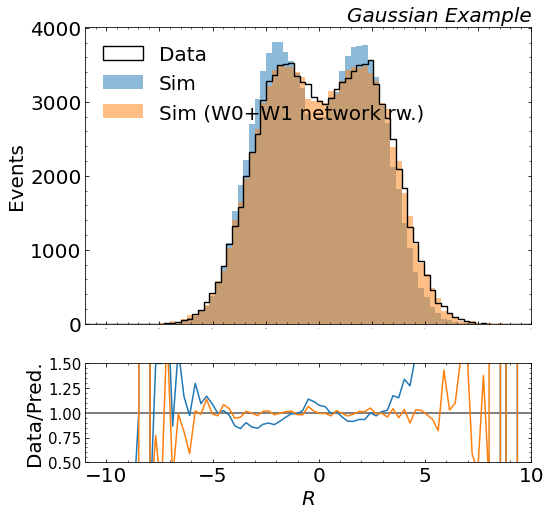

<Figure size 432x288 with 0 Axes>

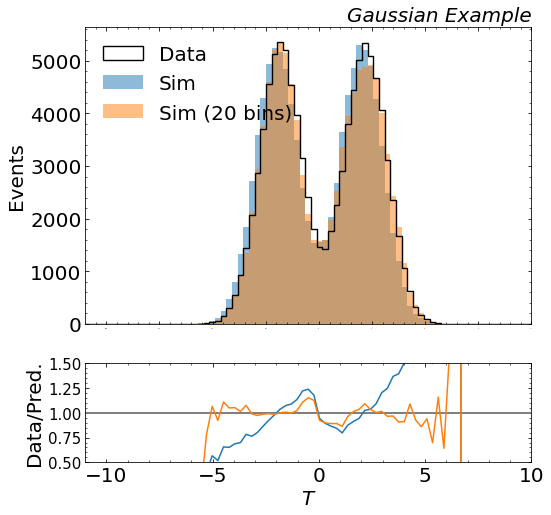

<Figure size 432x288 with 0 Axes>

In [22]:
# Test the trained W0 model and fitted theta value

w0_model_network_0 = w0_model_network
# theta = torch.tensor(2.5)
# w0_model_name_0 = 'w0_v1_epsilon0.2_mu0.8sigma1.5_20bins_sigmoid_2022-10-07'
# w0_model_name_1 = 'w0_v1_mu0.8sigma1.5_20bins_sigmoid_2022-09-29'
# w0_model_name_2 = 'w0_v1_mu0.8sigma1.5_20bins_Lr0p0001_2022-10-07'
# w0_model_name_3 = 'w0_v1_mu0.8sigma1.5_20bins_sigmoid_Lr0p0001_2022-10-07'
# w0_model_name_0 = 'w0_v1_20bins_2022-09-29'
# w0_model_name_1 = 'w0_v1_5bins_2022-09-29'
# w0_model_name_2 = 'w0_v1_20bins_sigmoid_2022-09-29'
# w0_model_network_0 = torch.load(f'model/w0/{w0_model_name_0}.pth')
# w0_model_network_1 = torch.load(f'model/w0/{w0_model_name_1}.pth')
# w0_model_network_2 = torch.load(f'model/w0/{w0_model_name_2}.pth')
# w0_model_network_3 = torch.load(f'model/w0/{w0_model_name_3}.pth')

today = str(datetime.date.today())

Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1_model_analytic, theta_model, loss_fn)
Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()


# Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = test_w0(w0_dataloader_test, w0_model_network_0, w1_model_analytic, theta_model, loss_fn)
# Ts_0, Rs_0, Ws_0, W0s_0, W1s_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy(), W0s_0.cpu().numpy(), W1s_0.cpu().numpy()

# Ts_1, Rs_1, Ws_1, W0s_1, W1s_1 = test_w0(w0_dataloader_test, w0_model_network_1, w1_model_analytic, theta, loss_fn)
# Ts_1, Rs_1, Ws_1, W0s_1, W1s_1 = Ts_1.cpu().numpy(), Rs_1.cpu().numpy(), Ws_1.cpu().numpy(), W0s_1.cpu().numpy(), W1s_1.cpu().numpy()

# Ts_2, Rs_2, Ws_2, W0s_2, W1s_2 = test_w0(w0_dataloader_test, w0_model_network_2, w1_model_analytic, theta, loss_fn)
# Ts_2, Rs_2, Ws_2, W0s_2, W1s_2 = Ts_2.cpu().numpy(), Rs_2.cpu().numpy(), Ws_2.cpu().numpy(), W0s_2.cpu().numpy(), W1s_2.cpu().numpy()

# Ts_3, Rs_3, Ws_3, W0s_3, W1s_3 = test_w0(w0_dataloader_test, w0_model_network_3, w1_model_analytic, theta, loss_fn)
# Ts_3, Rs_3, Ws_3, W0s_3, W1s_3 = Ts_3.cpu().numpy(), Rs_3.cpu().numpy(), Ws_3.cpu().numpy(), W0s_3.cpu().numpy(), W1s_3.cpu().numpy()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$R$", density=False, save_name=f"Compare_R_{today}")
cpwr.add_data(R_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0, label="Sim", alpha=0.5, color='tab:blue')
# cpwr.add_data(Rs_0, weights=Ws_0, label="Sim (20 bins)", alpha=0.5, color='tab:orange')
# cpwr.add_data(Rs_1, weights=Ws_1, label="Sim (60 bins sgmd)", color='tab:red', histtype="step", ls="--", lw=1.4)
# cpwr.add_data(Rs_2, weights=Ws_2, label="Sim (20 bins)", color='blue', histtype="step", ls=":", lw=1.4)
cpwr.add_data(Rs_0, weights=Ws_0, label="Sim (W0+W1 network rw.)", alpha=0.5, color='tab:orange')
# cpwr.add_data(Rs_1, weights=Ws_1, label="Sim (20 bins sgmd Lr=0.001)", color='tab:red', histtype="step", ls="--", lw=1.4)
# cpwr.add_data(Rs_2, weights=Ws_2, label="Sim (rw. 20 bins Lr=0.0001)", color='blue', histtype="step", ls=":", lw=1.4)
# cpwr.add_data(Rs_3, weights=Ws_3, label="Sim (20 bins sgmd Lr=0.0001)", color='green', histtype="step", ls="-.", lw=1.4)
cpwr.show()

# cpwr = comparison_plots_with_ratio(-11, 5, 80, xlabel=r"$R$", density=True, save_name=f"Compare_R_{today}")
# cpwr.add_data(R_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
# cpwr.add_data(Rs_0, label="Sim", alpha=0.5, color='tab:blue')
# cpwr.add_data(Rs_0, weights=Ws_0, label="Sim (W1 analytic rw.)", alpha=0.5, color='tab:orange')
# cpwr.show()

cpwr = comparison_plots_with_ratio(-11, 10, 80, xlabel=r"$T$", density=False, save_name=f"Compare_T_{today}")
cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (20 bins)", alpha=0.5, color='tab:orange')
# cpwr.add_data(Ts_1, weights=W0s_1, label="Sim (60 bins sgmd)", color='tab:red', histtype="step", ls="--", lw=1.4)
# cpwr.add_data(Ts_2, weights=W0s_2, label="Sim (20 bins)", color='blue', histtype="step", ls=":", lw=1.4)
# cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (rw. 20 bins Lr=0.001)", alpha=0.5, color='tab:orange')
# cpwr.add_data(Ts_1, weights=W0s_1, label="Sim (20 bins sgmd Lr=0.001)", color='tab:red', histtype="step", ls="--", lw=1.4)
# cpwr.add_data(Ts_2, weights=W0s_2, label="Sim (rw. 20 bins Lr=0.0001)", color='blue', histtype="step", ls=":", lw=1.4)
# cpwr.add_data(Ts_3, weights=W0s_3, label="Sim (20 bins sgmd Lr=0.0001)", color='green', histtype="step", ls="-.", lw=1.4)
cpwr.show()

# cpwr = comparison_plots_with_ratio(-11, 5, 80, xlabel=r"$T$", density=True, save_name=f"Compare_T_{today}")
# cpwr.add_data(T_data, label="Data", target=True, color='black', histtype="step", ls="-", lw=1.4)
# cpwr.add_data(Ts_0, label="Sim", alpha=0.5, color='tab:blue')
# cpwr.add_data(Ts_0, weights=W0s_0, label="Sim (20 bins)", alpha=0.5, color='tab:orange')
# cpwr.show()

# plt.hist(Ws_0, density=False, bins=100, label="Weights (20 bins)", alpha=0.5)
# plt.hist(Ws_1, density=False, bins=100, label="Weights (60 bins sgmd)", alpha=0.5)
# plt.hist(Ws_2, density=False, bins=100, label="Weights (20 bins)", alpha=0.5)
# plt.hist(Ws_0, density=False, bins=100, label="Weights (20 bins)", alpha=0.5)
# plt.hist(Ws_1, density=False, bins=100, label="Weights (5 bins)", alpha=0.5)
# plt.hist(Ws_2, density=False, bins=100, label="Weights (20 bins sigm)", alpha=0.5)
# plt.xlabel('Weight')
# plt.ylabel('Number of events')
# plt.title(r'Weight distribution')
# plt.legend(loc='upper right')#, framealpha=0)
# plt.tight_layout()
# plt.show()